In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.metrics import r2_score

In [ ]:
data = pd.read_csv("MELBOURNE_HOUSE_PRICES_LESS.csv")

In [ ]:
data


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Postcode,Regionname,Propertycount,Distance,CouncilArea
0,Abbotsford,49 Lithgow St,3,h,1490000.0,S,Jellis,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
1,Abbotsford,59A Turner St,3,h,1220000.0,S,Marshall,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
2,Abbotsford,119B Yarra St,3,h,1420000.0,S,Nelson,1/04/2017,3067,Northern Metropolitan,4019,3.0,Yarra City Council
3,Aberfeldie,68 Vida St,3,h,1515000.0,S,Barry,1/04/2017,3040,Western Metropolitan,1543,7.5,Moonee Valley City Council
4,Airport West,92 Clydesdale Rd,2,h,670000.0,S,Nelson,1/04/2017,3042,Western Metropolitan,3464,10.4,Moonee Valley City Council
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63018,Roxburgh Park,3 Carr Pl,3,h,566000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63019,Roxburgh Park,9 Parker Ct,3,h,500000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63020,Roxburgh Park,5 Parkinson Wy,3,h,545000.0,S,Raine,31/03/2018,3064,Northern Metropolitan,5833,20.6,Hume City Council
63021,Thomastown,3/1 Travers St,3,u,NaN,PI,Barry,31/03/2018,3074,Northern Metropolitan,7955,15.3,Whittlesea City Council


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63023 entries, 0 to 63022
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         63023 non-null  object 
 1   Address        63023 non-null  object 
 2   Rooms          63023 non-null  int64  
 3   Type           63023 non-null  object 
 4   Price          48433 non-null  float64
 5   Method         63023 non-null  object 
 6   SellerG        63023 non-null  object 
 7   Date           63023 non-null  object 
 8   Postcode       63023 non-null  int64  
 9   Regionname     63023 non-null  object 
 10  Propertycount  63023 non-null  int64  
 11  Distance       63023 non-null  float64
 12  CouncilArea    63023 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 6.3+ MB


PreProcessing

In [ ]:
def onehot_encode(df,column_dict):
  df= df.copy()
  for column , prefix in column_dict.items():
    dummies = pd.get_dummies(df[column],prefix=prefix)
    df= pd.concat([df,dummies],axis=1)
    df = df.drop(column,axis=1)
  return df  

In [ ]:
def get_sequences(texts):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(texts)
  vocab_length=len(tokenizer.word_index)+ 1
  print("Vocab Length: ",vocab_length)
  sequences=tokenizer.texts_to_sequences(texts)
  max_seq_length =np.max([len(sequence)for sequence in sequences])
  print("Max Sequence Length :",max_seq_length)
  sequences=pad_sequences(sequences,maxlen=max_seq_length,padding='post')
  return sequences

In [ ]:
def preprocess_inputs(df):
  df = df.copy()
  #drop rows with missing values
  df = df.dropna(axis=0).reset_index(drop=True)
  #one hot encode nominal features 
  column_dict= {
     'CouncilArea': 'SU',
     'Method': 'ME',
     'Postcode': 'PO',
     'Regionname': 'RO',
     'SellerG': 'SE',
     'Suburb': 'SU',
     'Type': 'TY',
    }

  df= onehot_encode(df,column_dict)

  #Create date features
  df['Date'] = pd.to_datetime(df['Date'])
  df['Year'] = df['Date'].apply(lambda x: x.year)
  df['Month'] = df['Date'].apply(lambda x: x.month)
  df['Day'] = df['Date'].apply(lambda x: x.day)
  df=df.drop('Date',axis=1)

  #get address sequences
  addr_sequences = get_sequences(df['Address'])
  df=df.drop('Address', axis=1)

  #split df into X and y
  y=df['Price'].copy()
  X=df.drop('Price',axis =1).copy()

  #Scale X with a standard scaler
  scaler = StandardScaler()
  X=pd.DataFrame(scaler.fit_transform(X),columns= X.columns)
  return X,addr_sequences,y

In [ ]:
X,addr_sequences,y =preprocess_inputs(data)

Vocab Length:  10774
Max Sequence Length : 5


In [ ]:
X

,Rooms,Propertycount,Distance,SU_Banyule City Council,SU_Bayside City Council,SU_Boroondara City Council,SU_Brimbank City Council,SU_Cardinia Shire Council,SU_Casey City Council,SU_Darebin City Council,...,SU_Yarra Junction,SU_Yarraville,SU_croydon,SU_viewbank,TY_h,TY_t,TY_u,Year,Month,Day
0,-0.075861,-0.795852,-1.285142,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,-0.053884,-1.909231,-1.448953
1,-0.075861,-0.795852,-1.285142,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,-0.053884,-1.909231,-1.448953
2,-0.075861,-0.795852,-1.285142,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,-0.053884,-1.909231,-1.448953
3,-0.075861,-1.351338,-0.689112,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,-0.053884,-1.909231,-1.448953
4,-1.134401,-0.920365,-0.305003,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,-0.053884,-1.909231,-1.448953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48428,-1.134401,2.128749,3.350649,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,-1.547116,-0.338536,2.052397,1.259546,-1.258706,1.773269
48429,-0.075861,1.572814,-0.569906,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,3.604149,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,1.259546,-1.258706,1.773269
48430,-0.075861,-0.388885,1.045999,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,1.259546,-1.258706,1.773269
48431,-0.075861,-0.388885,1.045999,-0.252461,-0.23305,-0.277156,-0.24393,-0.032784,-0.084454,-0.277458,...,-0.004544,-0.08544,-0.004544,-0.004544,0.646364,-0.338536,-0.487235,1.259546,-1.258706,1.773269


In [ ]:
y

0        1490000.0
1        1220000.0
2        1420000.0
3        1515000.0
4         670000.0
           ...    
48428     347700.0
48429     808000.0
48430     566000.0
48431     500000.0
48432     545000.0
Name: Price, Length: 48433, dtype: float64

In [ ]:
y.isna()


0        False
1        False
2        False
3        False
4        False
         ...  
48428    False
48429    False
48430    False
48431    False
48432    False
Name: Price, Length: 48433, dtype: bool

In [ ]:
addr_sequences

array([[  66, 2804,    1,    0,    0],
       [2408,  418,    1,    0,    0],
       [6811,  313,    1,    0,    0],
       ...,
       [   7, 3345,   26,    0,    0],
       [  15,  779,    6,    0,    0],
       [  10, 6711,   36,    0,    0]], dtype=int32)

Training

In [ ]:
X_train,X_test,addr_train,addr_test,y_train,y_test=train_test_split(X,addr_sequences,y,train_size=0.7,random_state=123)

In [ ]:
X_train.shape[1]

1069

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_input (InputLayer)           [(None, 1069)]       0           []                               
                                                                                                  
 addr_input (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 X_dense1 (Dense)               (None, 512)          547840      ['X_input[0][0]']                
                                                                                                  
 addr_embedding (Embedding)     (None, 5, 64)        689536      ['addr_input[0][0]']             
                                                                                            

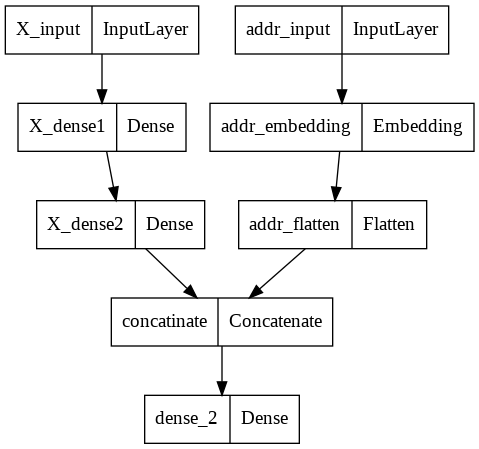

In [ ]:
X_inputs=tf.keras.Input(shape=(X_train.shape[1],),name='X_input')
addr_inputs=tf.keras.Input(shape=(addr_train.shape[1],), name='addr_input')
#X
X_dense1=tf.keras.layers.Dense(512,activation='relu',name='X_dense1')(X_inputs)
X_dense2=tf.keras.layers.Dense(512,activation='relu',name='X_dense2')(X_dense1)
#addr
addr_embedding=tf.keras.layers.Embedding(
    input_dim=10774,
    output_dim=64,
    input_length=addr_train.shape[1],
    name='addr_embedding'
)(addr_inputs)
addr_flatten = tf.keras.layers.Flatten(name='addr_flatten')(addr_embedding)

#concatinate 
concat =tf.keras.layers.concatenate([X_dense2, addr_flatten],name='concatinate')
outputs=tf.keras.layers.Dense(1,activation='linear')(concat)
model=tf.keras.Model(inputs=[X_inputs,addr_inputs], outputs=outputs)
print(model.summary())
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mse'
)
history=model.fit(
    [X_train,addr_train],
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
               tf.keras.callbacks.EarlyStopping(
                   monitor='val_loss',
                   patience=3,
                   restore_best_weights=True
               ),
               tf.keras.callbacks.ReduceLROnPlateau()
    ]
)

Epoch 1/50
848/848 [==============================] - 17s 19ms/step - loss: 196385112064.0000 - val_loss: 144969252864.0000 - lr: 0.1000
Epoch 2/50
848/848 [==============================] - 17s 20ms/step - loss: 109256376320.0000 - val_loss: 123931410432.0000 - lr: 0.1000
Epoch 3/50
848/848 [==============================] - 16s 19ms/step - loss: 97739022336.0000 - val_loss: 117992128512.0000 - lr: 0.1000
Epoch 4/50
848/848 [==============================] - 16s 19ms/step - loss: 88316502016.0000 - val_loss: 116389896192.0000 - lr: 0.1000
Epoch 5/50
848/848 [==============================] - 16s 18ms/step - loss: 81003503616.0000 - val_loss: 115401629696.0000 - lr: 0.1000
Epoch 6/50
848/848 [==============================] - 16s 19ms/step - loss: 75617107968.0000 - val_loss: 121018163200.0000 - lr: 0.1000
Epoch 7/50
848/848 [==============================] - 16s 19ms/step - loss: 71138525184.0000 - val_loss: 142959591424.0000 - lr: 0.1000
Epoch 8/50
848/848 [==========================

Results

In [ ]:
y_true=np.array(y_test)
y_pred=np.squeeze(model.predict([X_test,addr_test]))

In [ ]:
model_r2 =r2_score(y_true,y_pred)
print('Model R2 Score:{:0.6f}'.format(model_r2))

Model R2 Score:0.724487
